In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import stats
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from sklearn import preprocessing
plt.style.use('seaborn')
import seaborn as sns
from geopy.distance import vincenty
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier


## Data cleaning
### deal with missing data

In [57]:
df = pd.read_csv('listings.csv')
df.shape

/Users/luyongfei/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(8652, 106)

In [59]:
boolean_cols = ['host_is_superhost', 
               'host_has_profile_pic',
               'host_identity_verified',
               'is_location_exact',
               'has_availability',
               'requires_license',
               'instant_bookable',
               'is_business_travel_ready',
               'require_guest_profile_picture',
               'require_guest_phone_verification']

def booleans_to_numbers(s):
    '''
    Converts "first letter boolean" strings to integers
    
    Args:
        bool_string (string): 't', 'f' or other
    
    Returns:
        bool_number (int): 1, 0 or None
    '''
    
    
    if s == 'f':
        return 0
    elif s == 't':
        return 1
    return None

In [60]:
for col in boolean_cols:
    print(col)
    df[col] = df[col].apply(booleans_to_numbers)
    

host_is_superhost
host_has_profile_pic
host_identity_verified
is_location_exact
has_availability
requires_license
instant_bookable
is_business_travel_ready
require_guest_profile_picture
require_guest_phone_verification


In [61]:
df['host_is_superhost'].value_counts()

0    5267
1    3385
Name: host_is_superhost, dtype: int64

In [62]:
def no_smoking(house_rules_txt):
    '''
    Checks whether smoking is prohibited by the house rules
    
    Args:
        house_rules_txt (string): house rules as specified by the host
    
    Returns:
        is_no_smoking (int): 1 if smoking is prohibited else 0
    '''
    
    is_no_smoking = int('no smoking' in str(house_rules_txt).lower() or 'smoking is not allowed' in str(house_rules_txt).lower())  

    return is_no_smoking

def no_pets(house_rules_txt):
    '''
    Checks whether pets are prohibited by the house rules
    
    Args:
        house_rules_txt (string): house rules as specified by the host
    
    Returns:
        is_no_pets (int): 1 if pets are prohibited else 0
    ''' 
    
    is_no_pets = int('no pets' in str(house_rules_txt).lower() or 'no smoking or pets' in str(house_rules_txt).lower())
    
    return is_no_pets



In [63]:
df['house_rules_no_smoking'] = df.house_rules.apply(no_smoking)
df['house_rules_no_pets'] = df.house_rules.apply(no_pets)


In [64]:
df['is_TV'] = df.amenities.apply(lambda s: int('TV' in str(s)[1:].split(',')))
df['is_Wifi'] = df.amenities.apply(lambda s: int('Wifi' in str(s)[1:].split(',')))
df['amenities_number'] = df.amenities.apply(lambda s: len(str(s)[1:].split(',')))


In [65]:
df.isnull().sum().sort_values(ascending=False).head(20)

xl_picture_url                  8652
host_acceptance_rate            8652
neighbourhood_group_cleansed    8652
medium_url                      8652
thumbnail_url                   8652
square_feet                     8586
monthly_price                   8077
weekly_price                    8052
notes                           3731
access                          2846
host_about                      2742
interaction                     2606
transit                         2370
house_rules                     2296
security_deposit                2130
neighborhood_overview           2128
space                           1667
review_scores_communication     1232
review_scores_checkin           1231
review_scores_location          1231
dtype: int64

In [66]:
df.shape

(8652, 111)

In [67]:
df['price'] = df['price'].str.replace('[\$,]','',regex=True).astype(float)


In [68]:
lat_center_dict = {1: 41.8500300}
lon_center_dict = {1: -87.6500500}
df['lat_center'] = 41.8500300
df['lon_center'] = -87.6500500

In [69]:
df['distance_center'] = df.apply(
    lambda x: vincenty((x['latitude'], 
                        x['longitude']), 
                       (x['lat_center'], 
                        x['lon_center'])).km, 
    axis = 1)

/Users/luyongfei/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [70]:
df['distance_center'].describe()

count    8652.000000
mean        8.148179
std         4.359295
min         0.340597
25%         4.931079
50%         7.359590
75%        10.905901
max        23.816270
Name: distance_center, dtype: float64

In [71]:
df_m = df[['host_is_superhost','neighbourhood_cleansed',
             'price', 'host_since','room_type',
             'reviews_per_month','number_of_reviews', 
             'distance_center', 'longitude', 'latitude',
             'cancellation_policy', 'security_deposit', 
             'cleaning_fee', 'beds', 'bedrooms', 'bathrooms',
             'accommodates', 'host_response_time',
             'host_identity_verified', 'availability_30', 
             'instant_bookable','review_scores_rating',
             'host_response_rate', 'is_TV', 'is_Wifi',
             'amenities_number', 'availability_90', 'availability_365']].copy()

In [72]:
df_m.isna().sum()

host_is_superhost            0
neighbourhood_cleansed       0
price                        0
host_since                   0
room_type                    0
reviews_per_month         1164
number_of_reviews            0
distance_center              0
longitude                    0
latitude                     0
cancellation_policy          1
security_deposit          2130
cleaning_fee               929
beds                         2
bedrooms                     1
bathrooms                    4
accommodates                 0
host_response_time        1037
host_identity_verified       0
availability_30              0
instant_bookable             0
review_scores_rating      1230
host_response_rate        1037
is_TV                        0
is_Wifi                      0
amenities_number             0
availability_90              0
availability_365             0
dtype: int64

In [73]:
# host_response_rate
df_m['host_response_rate'].fillna('0%', inplace = True)
df_m['host_response_rate'] = df_m['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [74]:
df_m['host_response_time'].fillna('Missing', inplace = True)


In [75]:
# If cleaning fee is missing, then we assume it to be 0 since charges should have been clarified on the platform
df_m['cleaning_fee'].fillna('$0.00', inplace = True)
df_m['cleaning_fee'] = df_m['cleaning_fee'].replace('[\$,]','',regex=True).astype(float)


In [76]:
# If security_deposit is missing, then we assume it to be 0 since charges should have been clarified on the platform
df_m['security_deposit'].fillna('$0.00', inplace = True)
df_m['security_deposit'] = df_m['security_deposit'].str.replace('[\$,]','',regex=True).astype(float)

In [77]:

df_m['reviews_per_month'].fillna(0.0, inplace = True)
rating_mean = df_m['review_scores_rating'].mean()
df_m['review_scores_rating'].fillna(rating_mean, inplace = True)


In [78]:
df_m['cancellation_policy']

0       strict_14_with_grace_period
1                          moderate
2                          moderate
3       strict_14_with_grace_period
4                          moderate
                   ...             
8647                       moderate
8648                       moderate
8649                       moderate
8650                       flexible
8651    strict_14_with_grace_period
Name: cancellation_policy, Length: 8652, dtype: object

In [79]:
df_m['cancellation_policy'].fillna('strict', inplace = True)

In [80]:
df_m.isna().sum()

host_is_superhost         0
neighbourhood_cleansed    0
price                     0
host_since                0
room_type                 0
reviews_per_month         0
number_of_reviews         0
distance_center           0
longitude                 0
latitude                  0
cancellation_policy       0
security_deposit          0
cleaning_fee              0
beds                      2
bedrooms                  1
bathrooms                 4
accommodates              0
host_response_time        0
host_identity_verified    0
availability_30           0
instant_bookable          0
review_scores_rating      0
host_response_rate        0
is_TV                     0
is_Wifi                   0
amenities_number          0
availability_90           0
availability_365          0
dtype: int64

In [81]:
df_m.dropna(inplace=True)

In [82]:
df_m.shape

(8646, 28)

In [133]:
df_m['neighbourhood_cleansed']

0             Hyde Park
1        South Lawndale
2             West Town
3          Lincoln Park
4             Hyde Park
             ...       
8647       Lincoln Park
8648       Lincoln Park
8649       Lincoln Park
8650       North Center
8651    Near North Side
Name: neighbourhood_cleansed, Length: 8646, dtype: object

## convert data type

In [134]:
df_m1 = df_m.copy()
df_m1['host_response_time'].value_counts()

within an hour        6311
Missing               1036
within a few hours     795
within a day           437
a few days or more      67
Name: host_response_time, dtype: int64

In [135]:
df_m1['host_response_time'] = df_m1.where(df_m1['host_response_time'] != 'within an hour', 1)

df_m1['host_response_time'] = df_m1.where(df_m1['host_response_time'] != 'within a few hours', 2)

df_m1['host_response_time'] = df_m1.where(df_m1['host_response_time'] != 'within a day', 3)

df_m1['host_response_time'] = df_m1.where(df_m1['host_response_time'] != 'a few days or more', 4)

df_m1['host_response_time'] = df_m1.where(df_m1['host_response_time'] != 'Missing', 5)

df_m1['host_response_time'] = df_m1['host_response_time'].astype('float64')


In [136]:
df_m1['host_is_superhost'] = df_m1['host_is_superhost'].where(df_m1['host_is_superhost'] != 't', 1)

df_m1['host_is_superhost'] = df_m1['host_is_superhost'].where(df_m1['host_is_superhost'] != 'f', 0)

df_m1['host_is_superhost'] = df_m1['host_is_superhost'].astype('float64')

/Users/luyongfei/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [137]:
df_m1['host_identity_verified'] = df_m1['host_identity_verified'].where(df_m1['host_identity_verified'] != 't', 1)
df_m1['host_identity_verified'] = df_m1['host_identity_verified'].where(df_m1['host_identity_verified'] != 'f', 0)
df_m1['host_identity_verified'] = df_m1['host_identity_verified'].astype('float64')

In [138]:
df_m1['host since'] = pd.to_datetime(df_m1['host_since'], format = '%Y-%m-%d')
df_m1['now'] = datetime(2019, 8, 1)
df_m1['host time'] = (df_m1['now'] - df_m1['host since']).dt.days


In [139]:

df_c = pd.read_csv('crimes.csv')

In [140]:
crimes = []
for i in range(75):
    n,c = df_c.iloc[i]['neighborhood'], df_c.iloc[i]['crime rate']
    crimes.append((n,c))
crimes

[('West Town', 81.0),
 ('Near North Side', 105.9),
 ('Lake View', 46.7),
 ('Logan Square', 58.8),
 ('Loop', 223.1),
 ('Near West Side', 121.9),
 ('Lincoln Park', 56.4),
 ('Lower West Side', 59.4),
 ('Uptown', 49.0),
 ('Edgewater', 37.1),
 ('Irving Park', 44.7),
 ('Avondale', 50.3),
 ('Near South Side', 63.1),
 ('Rogers Park', 55.7),
 ('North Center', 30.6),
 ('Bridgeport', 36.9),
 ('Hyde Park', 55.8),
 ('Lincoln Square', 38.5),
 ('Grand Boulevard', 113.7),
 ('Woodlawn', 131.4),
 ('Portage Park', 40.7),
 ('Albany Park', 39.4),
 ('Douglas', 105.3),
 ('Armour Square', 63.5),
 ('West Ridge', 35.9),
 ('South Shore', 134.6),
 ('East Garfield Park', 179.9),
 ('Humboldt Park', 99.1),
 ('Austin', 116.8),
 ('Kenwood', 73.1),
 ('South Lawndale', 50.2),
 ('Jefferson Park', 31.0),
 ('North Lawndale', 167.2),
 ('Norwood Park', 25.2),
 ('Belmont Cragin', 46.3),
 ('Mckinley Park', 51.9),
 ('Dunning', 27.5),
 ('Greater Grand Crossing', 160.6),
 ('Brighton Park', 42.5),
 ('Washington Park', 192.9),
 ('O

In [142]:
def create_crime_df(df, crimes):
    frames = []
    for n, c in crimes:
        d = df[df['neighbourhood_cleansed'] == n].copy()
        d['avg yearly crimes'] = c
        frames.append(d)
    result = pd.concat(frames)
    return result

df_m1 = create_crime_df(df_m1, crimes)


In [143]:
df_m1['occupancy_rate'] = df_m1['reviews_per_month'] / 0.5 * (3 / 30) * 100
p1 = df_m1[df_m1['occupancy_rate'] <= 100].copy()
p2 = df_m1[df_m1['occupancy_rate'] > 100].copy()
p2['occupancy_rate'] = 100
df_m1 = pd.concat([p1, p2])


In [146]:
df_m1['occupancy_rate'].describe()

count    8646.000000
mean       38.909438
std        34.184191
min         0.000000
25%         7.600000
50%        30.400000
75%        66.000000
max       100.000000
Name: occupancy_rate, dtype: float64

In [147]:
df_m1['revenue'] = df_m1['reviews_per_month'] / 0.5 * 3 * df_m1['price']

In [148]:
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'flexible', 1.0)
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'moderate', 2.0)
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'strict_14_with_grace_period', 3.0)
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'strict', 4.0)
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'super_strict_30', 5.0)
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].where(df_m1['cancellation_policy'] != 'super_strict_60', 6.0)

In [149]:
df_m1['cancellation_policy'] = df_m1['cancellation_policy'].astype('float64')

In [150]:
df_m1['host_response_time'].value_counts()

0.0    5261
1.0    3385
Name: host_response_time, dtype: int64

Text(0.5, 1.0, 'difference of occupancy rate')

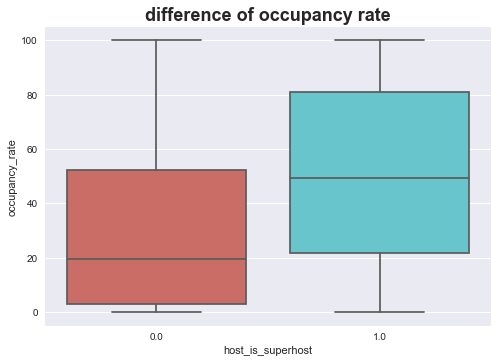

In [151]:
plt.style.use('seaborn')
sb.boxplot(x='host_is_superhost', y='occupancy_rate',
           data=df_m1,
           palette='hls')
plt.title('difference of occupancy rate', fontsize=18, fontweight='bold')

In [152]:
df_m1.shape

(8646, 34)

In [153]:
df_m1['room_type'] = df_m1['room_type'].where(df_m1['room_type'] != 'Shared room', 1.0)
df_m1['room_type'] = df_m1['room_type'].where(df_m1['room_type'] != 'Private room', 2.0)
df_m1['room_type'] = df_m1['room_type'].where(df_m1['room_type'] != 'Entire home/apt', 3.0)
df_m1['room_type'] = df_m1['room_type'].astype('float64')
df_m1['room_type'].value_counts()

3.0    5929
2.0    2506
1.0     211
Name: room_type, dtype: int64

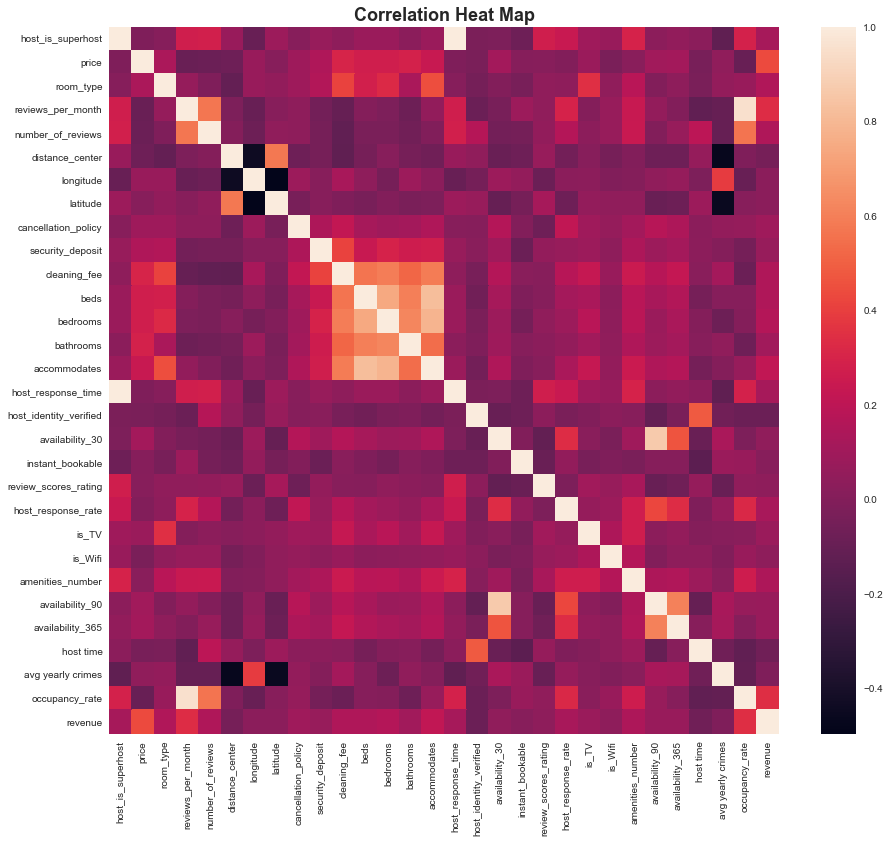

In [154]:
plt.figure(figsize=(15,13))
sns.heatmap(df_m1.corr())
plt.title('Correlation Heat Map', fontsize=18, fontweight='bold')
plt.show()

In [155]:
df_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8646 entries, 2 to 6963
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   host_is_superhost       8646 non-null   float64       
 1   neighbourhood_cleansed  8646 non-null   object        
 2   price                   8646 non-null   float64       
 3   host_since              8646 non-null   object        
 4   room_type               8646 non-null   float64       
 5   reviews_per_month       8646 non-null   float64       
 6   number_of_reviews       8646 non-null   int64         
 7   distance_center         8646 non-null   float64       
 8   longitude               8646 non-null   float64       
 9   latitude                8646 non-null   float64       
 10  cancellation_policy     8646 non-null   float64       
 11  security_deposit        8646 non-null   float64       
 12  cleaning_fee            8646 non-null   float64 

In [156]:
df_m1.drop(['host since', 'now','host_since', 'neighbourhood_cleansed'],
           axis=1, inplace=True)

In [157]:
# drop outliers
df_g = df_m1[df_m1['revenue'] <20000].copy()

In [158]:
df_g['avg yearly crimes'].describe()

count    8621.000000
mean       81.670792
std        48.407242
min        17.000000
25%        46.700000
50%        59.400000
75%       105.900000
max       263.300000
Name: avg yearly crimes, dtype: float64

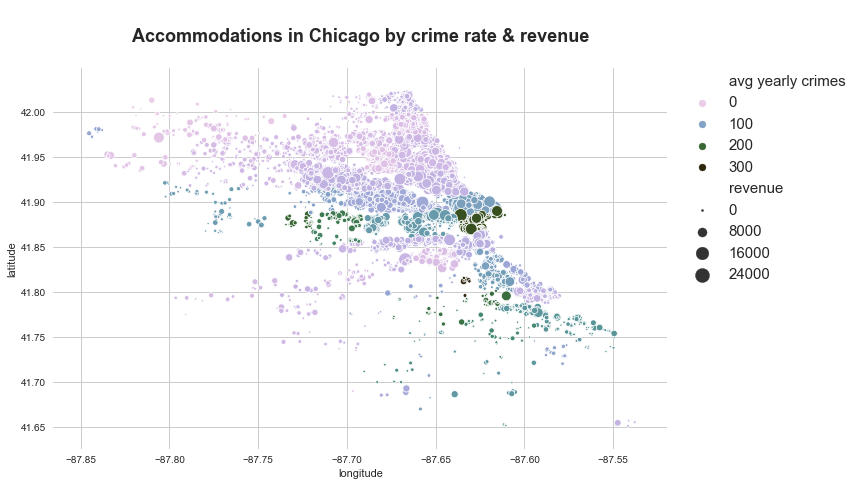

In [159]:
sns.set_style("whitegrid")
cmap = sns.cubehelix_palette(start=0.9, rot=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,7))

ax = sns.scatterplot(x="longitude", y="latitude", size='revenue', sizes=(5, 200),
                     hue='avg yearly crimes', palette=cmap,  data=df_g)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0., fontsize=15,)
plt.title('\nAccommodations in Chicago by crime rate & revenue\n', fontsize=18, fontweight='bold')
plt.savefig('locations')
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

## Models

1000.0


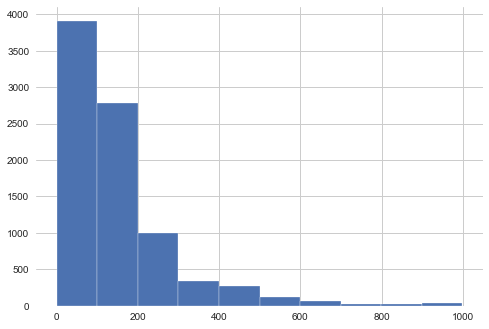

In [160]:
## KNN model

v1 = df_m1['price'].quantile(0.99)
print(v1)
p = df_m1[df_m1['price']< v1]['price']
plt.hist(p)
df_knn = df_m1[df_m1['price']< v1].copy()

In [161]:
col1 = ['host_response_rate', 'host_is_superhost', 'room_type', 
        'accommodates', 'bathrooms','security_deposit', 'beds',
        'bedrooms', 'cleaning_fee', 
        'cancellation_policy', 'review_scores_rating',
        'number_of_reviews', 'host time','avg yearly crimes']

X = preprocessing.scale(df_knn[col1])
y = df_knn['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75,
                                                    random_state=0)



In [163]:
knn = KNeighborsRegressor(algorithm='brute',n_neighbors=5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** (1/2)
rmse

89.23593917492273

In [164]:
X_s = df_knn[col1].copy()
X_s['host_is_superhost'] = 1
X_s
pred_s = knn.predict(X_s)

X_ns = df_knn[col1].copy()
X_ns['host_is_superhost'] = 0
X_ns
pred_ns = knn.predict(X_ns)

In [165]:
d = {'superhost price': pred_s, 'non-superhost price': pred_ns}
pf = pd.DataFrame(data=d)

In [166]:
# Welch’s t-test statistics
t, p = stats.ttest_ind(pred_s, pred_ns)

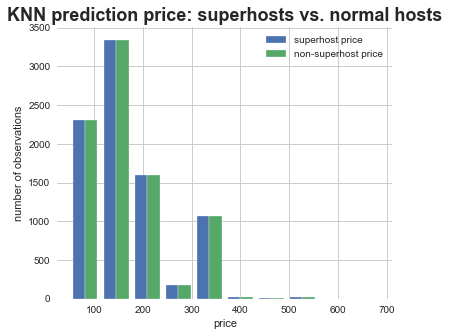

    Welch’s t-test statistics:
    T value: -0.034583596067340294
    p value: 0.9724121859140163


In [167]:
x = pf['superhost price']
y = pf['non-superhost price']
plt.figure(figsize = (6, 5))
plt.hist([x, y], label=['superhost price', 'non-superhost price'])
plt.legend(loc='upper right')
plt.xlabel('price')
plt.ylabel('number of observations')
plt.title('KNN prediction price: superhosts vs. normal hosts',
          fontsize = 18, fontweight='bold')
plt.show()
print('    Welch’s t-test statistics:')
print('    T value:', t)
print('    p value:', p)

5858.1900000000005


(8213, 30)

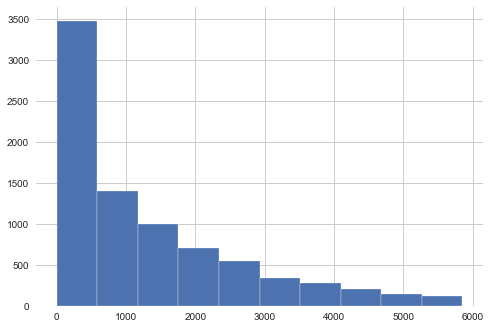

In [168]:
# decision tree
# drop extremely high revenue observations
v_t = df_m1['revenue'].quantile(0.95)
print(v_t)
df_t = df_m1[df_m1['revenue'] < v_t]
plt.hist(df_t['revenue'])
df_t.shape


In [169]:

y_t = df_t['revenue'].values
X_t = df_t[['host_is_superhost',  'room_type',
          'accommodates', 'bathrooms', 'bedrooms', 'beds', 
          'price', 'cleaning_fee',  
          'review_scores_rating', 'cancellation_policy', 'number_of_reviews',
          'host time',  'occupancy_rate']].values

X_ttrain, X_ttest, y_ttrain, y_ttest = train_test_split(X_t, y_t, train_size=0.7)

r_tree = DecisionTreeRegressor(max_depth= 10, min_samples_split=5)
r_tree.fit(X_ttrain, y_ttrain)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [170]:
r_tree_viz = export_graphviz(
    r_tree,
    out_file=None,
    feature_names=['host_is_superhost', 'room_type',
          'accommodates', 'bathrooms', 'bedrooms', 'beds', 
          'price', 'cleaning_fee', 
          'review_scores_rating', 'cancellation_policy', 'number_of_reviews',
          'host time',  'occupancy_rate'],
    class_names=df_t["revenue"],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(r_tree_viz)
graph.render('r_tree_viz')

graph

In [171]:
y_tpred = r_tree.predict(X_ttest)
MSE = mean_squared_error(y_ttest, y_tpred)
print('the test RMSE is {}'.format(np.sqrt(MSE)))

the test RMSE is 217.6058077800402


In [172]:
def superhost_significances(df, threshold = 0.01):
    '''
    Calculates superhost p-values and sorts them by ascending t-test statistics value
    Returns only columns with p-value < threshold

    Args:
        df (pandas dataframe): dataframe that contains column 'host_is_superhost'
        threshold (float, default = 0.01): upper bound for p-value to return
        
    Returns:
        res (pandas series): sorted series of columns with values in tuple
        (t-test statistic, p-value), an output of stats.ttest_ind
    '''
    
    df_t = df[df.host_is_superhost == 1]
    df_f = df[df.host_is_superhost == 0]
    res = pd.Series()
    for col in df.columns:
        t_test, p_val = stats.ttest_ind(df_t[col].dropna(), df_f[col].dropna(), equal_var = False)
        if p_val < threshold:
            res[col] = (t_test, p_val)
    return res.sort_values(ascending=False)


In [173]:
df_x = df_m1[['host_is_superhost', 'room_type',
          'accommodates', 'bathrooms', 'bedrooms', 'beds', 
          'price', 'cleaning_fee', 
          'review_scores_rating', 'cancellation_policy', 'number_of_reviews',
          'occupancy_rate']].copy()

In [174]:
l = superhost_significances(df_x,0.05)
l_t = []
l_p = []
for i in l:
    l_t.append(i[0])
    l_p.append(i[1])
    
l_i = l.index
dt = {'Variable': l_i, 'T value': l_t, 'P value': l_p}
df_w = pd.DataFrame(data= dt)
df_w.set_index('Variable')

/Users/luyongfei/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,T value,P value
Variable,,
host_is_superhost,inf,0.000000e+00
review_scores_rating,30.783945,6.041265e-196
occupancy_rate,28.246235,1.922976e-166
number_of_reviews,24.733898,5.242382e-128
bedrooms,7.370896,1.879644e-13
accommodates,7.310573,2.982563e-13
beds,6.943957,4.212726e-12
cleaning_fee,3.762768,1.692601e-04
bathrooms,2.446237,1.445767e-02


In [175]:
df_w.to_excel('diff.xlsx')

In [176]:
## regression

In [177]:
df_m1['log avg yearly crimes'] = np.log(df_m1['avg yearly crimes'])

In [178]:
df_m1['const'] = 1

1000.0


(8548,)

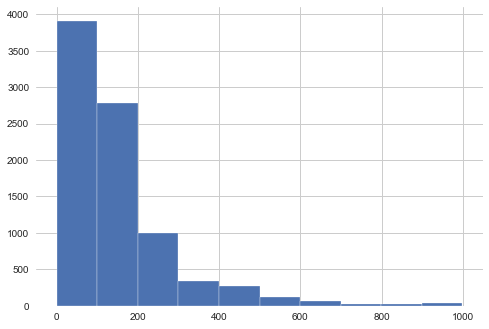

In [179]:
# we drop extremely high price observations
v1 = df_m1['price'].quantile(0.99)
print(v1)
p = df_m1[df_m1['price']< v1]['price']
plt.hist(p)
p.shape

In [180]:
df_reg1 = df_m1[df_m1['price']< v1]

In [181]:
y = df_reg1['price']
X1 = df_reg1[['const','host_is_superhost', 'log avg yearly crimes']]
X2 = df_reg1[['const','host_is_superhost', 'log avg yearly crimes', 'occupancy_rate','host time', 
            'host_response_rate', 'number_of_reviews','review_scores_rating']]

X3 = df_reg1[['const','host_is_superhost', 'log avg yearly crimes', 'occupancy_rate', 'host time', 
            'host_response_rate', 'number_of_reviews','review_scores_rating', 'cancellation_policy',
            'cleaning_fee', 'security_deposit', 'beds', 'bedrooms','bathrooms', 'accommodates']]


reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

info_dict={'R-squared' : lambda x: "{:.2f}".format(x.rsquared),
           'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'host_is_superhost',
                                             'avg yearly crimes',
                                             'log avg yearly crimes',
                                             'occupancy_rate',
                                             'host time',
                                             'host_response_rate',
                                             'number_of_reviews',
                                             'review_scores_rating',
                                             'cancellation_policy',
                                             'cleaning_fee',
                                             'security_deposit',
                                             'beds',
                                             'bedrooms',
                                             'bathrooms',
                                             'accommodates'])

results_table.add_title('Table 4.3(1) - price OLS Regressions')

print(results_table)

        Table 4.3(1) - price OLS Regressions
                      Model 1   Model 2    Model 3  
----------------------------------------------------
const                 -16.57   -111.71*** -183.06***
                      (12.18)  (25.67)    (21.06)   
host_is_superhost     -2.63    3.51       -4.96*    
                      (2.94)   (3.20)     (2.58)    
log avg yearly crimes 39.26*** 33.06***   25.92***  
                      (2.79)   (2.76)     (2.28)    
occupancy_rate                 -0.67***   -0.66***  
                               (0.05)     (0.04)    
host time                      -0.01***   -0.01***  
                               (0.00)     (0.00)    
host_response_rate             44.03***   4.80      
                               (4.57)     (3.80)    
number_of_reviews              -0.14***   -0.03     
                               (0.03)     (0.03)    
review_scores_rating           1.32***    1.15***   
                               (0.23)     (0.19)    
c

In [182]:
df_m1['revenue'].describe()

count      8646.000000
mean       1780.815184
std        4288.507866
min           0.000000
25%         204.000000
50%         918.000000
75%        2241.000000
max      187200.000000
Name: revenue, dtype: float64

In [183]:
# drop extremely high revenue observations
v = df_m1['revenue'].quantile(0.99)
print(v)
r = df_m1[df_m1['revenue'] < v]
r.shape


11632.49999999989


(8559, 32)

(array([4855., 1698.,  891.,  486.,  269.,  175.,   77.,   53.,   37.,
          18.]),
 array([    0.,  1155.,  2310.,  3465.,  4620.,  5775.,  6930.,  8085.,
         9240., 10395., 11550.]),
 <a list of 10 Patch objects>)

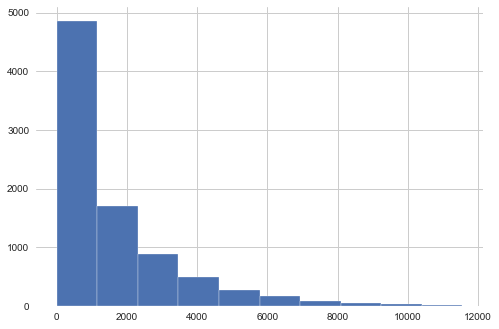

In [184]:
plt.hist(r['revenue'])

In [185]:

y1 = r['revenue']
X_1 = r[['const', 'host_is_superhost', 'occupancy_rate',
              'price', 'log avg yearly crimes']]
X_2 = r[['const', 'host_is_superhost', 'occupancy_rate',
             'price', 'log avg yearly crimes', 'host time',
             'number_of_reviews',
             'review_scores_rating', 'host_response_rate']]
X_3 = r[['const', 'host_is_superhost', 'occupancy_rate',
             'price', 'log avg yearly crimes', 'host time',
             'number_of_reviews','room_type',
             'review_scores_rating', 'host_response_rate',
             'cancellation_policy', 'security_deposit', 
             'cleaning_fee', 'beds', 'bedrooms', 'bathrooms',
             'accommodates']]
reg_1 = sm.OLS(y1, X_1, missing='drop').fit()
reg_2 = sm.OLS(y1, X_2, missing='drop').fit()
reg_3 = sm.OLS(y1, X_3, missing='drop').fit()


info_dict={'R-squared' : lambda x: "{:.2f}".format(x.rsquared),
           'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}

results_table1 = summary_col(results=[reg_1,reg_2,reg_3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 4',
                                         'Model 5',
                                         'Model 6'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'host_is_superhost',
                                             'occupancy_rate',
                                             'price',
                                             'log avg yearly crimes',
                                             'host time',
                                             'reviews_per_month',
                                             'number_of_reviews',
                                             'review_scores_rating',
                                             'host_response_rate',
                                             'cancellation_policy',
                                             'security_deposit',
                                             'cleaning_fee',
                                             'beds',
                                             'bedrooms',
                                             'bathrooms',
                                             'accommodates',
                                             'room_type'])

results_table1.add_title('Table 4.3(2) - revenue OLS Regressions')

print(results_table1)

         Table 4.3(2) - revenue OLS Regressions
                       Model 4     Model 5     Model 6  
--------------------------------------------------------
const                 -974.21*** -2056.02*** -3438.09***
                      (124.53)   (262.08)    (242.89)   
host_is_superhost     325.63***  310.84***   268.35***  
                      (30.86)    (32.68)     (28.97)    
occupancy_rate        35.95***   38.00***    36.64***   
                      (0.45)     (0.56)      (0.50)     
price                 1.08***    1.06***     0.53***    
                      (0.04)     (0.04)      (0.04)     
log avg yearly crimes 192.23***  182.03***   155.51***  
                      (28.22)    (28.30)     (25.60)    
host time                        -0.04**     -0.06***   
                                 (0.02)      (0.02)     
number_of_reviews                -2.78***    -1.98***   
                                 (0.32)      (0.28)     
review_scores_rating             11.57**

In [186]:
df_s= df_m1[['revenue','host_is_superhost', 'occupancy_rate',
             'price', 'log avg yearly crimes', 'host time',
             'number_of_reviews','room_type',
             'review_scores_rating', 'host_response_rate',
             'cancellation_policy', 'security_deposit', 
             'cleaning_fee', 'beds', 'bedrooms', 'bathrooms',
             'accommodates']].describe()

In [187]:
(df_s.T).to_csv('summary.csv')

In [191]:
df_s.T

,count,mean,std,min,25%,50%,75%,max
revenue,8646.0,1780.815184,4288.507866,0.000000,204.000000,918.000000,2241.000000,187200.000000
host_is_superhost,8646.0,0.391511,0.488116,0.000000,0.000000,0.000000,1.000000,1.000000
occupancy_rate,8646.0,38.909438,34.184191,0.000000,7.600000,30.400000,66.000000,100.000000
price,8646.0,176.640180,397.146114,0.000000,69.000000,109.000000,189.000000,10000.000000
log avg yearly crimes,8646.0,4.260983,0.512568,2.833213,3.843744,4.084294,4.662495,5.573294
host time,8646.0,1382.665510,791.903862,-16.000000,752.000000,1358.000000,1980.750000,4002.000000
number_of_reviews,8646.0,39.114157,57.724413,0.000000,3.000000,16.000000,51.000000,588.000000
room_type,8646.0,2.661346,0.522310,1.000000,2.000000,3.000000,3.000000,3.000000
review_scores_rating,8646.0,95.160217,6.332772,20.000000,94.000000,96.000000,99.000000,100.000000
host_response_rate,8646.0,0.856162,0.330304,0.000000,0.980000,1.000000,1.000000,1.000000
